In [0]:
from __future__ import division
from torch.backends import cudnn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

In [0]:
use_cuda=torch.cuda.is_available()
dtype=torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [0]:
def load_image(image_path,transform=None,max_size=None,shape=None):
  image=Image.open(image_path)
  
  if max_size is not None:
    scale=max_size / max(image.size)
    size=np.array(image.size)*scale
    image=image.resize(size.astype(int),Image.ANTIALIAS)
  
  if shape is not None:
    image=image.resize(shape,Image.LANCZOS)
  
  if transform is not None:
    image=transform(image).unsqueeze(0)
  
  return image.type(dtype)


In [0]:
class VGGNet(nn.Module):
  def __init__(self):
    super(VGGNet,self).__init__()
    self.select=['0','5','10','19','28']
    self.vgg=models.vgg19(pretrained=True).features
  
  def forward(self,x):
    features=[]
    for name,layer in self.vgg._modules.items():
      x=layer(x)
      if name in self.select:
        features.append(x)
    return features
  

In [0]:
def main(config):
  transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485,0.456,0.406),
                           (0.229,0.224,0.225))
  ])
  
  content=load_image(config['content'],transform,max_size=config['max_size'])
  style=load_image(config['style'],transform,shape=[content.size(2),content.size(3)])
  
  target=Variable(content.clone(),requires_grad=True)
  optimizer=torch.optim.Adam([target],lr=config['lr'],betas=[0.5,0.999])
  
  vgg=VGGNet()
  if use_cuda:
    vgg.cuda()
  
  for step in range(config['total_step']):
    target_features=vgg(target)
    content_features=vgg(Variable(content))
    style_features=vgg(Variable(style))
    
    style_loss=0
    content_loss=0
    
    for f1,f2,f3 in zip(target_features,content_features,style_features):
      content_loss += torch.mean((f1-f2)**2)
      
      _,c,h,w=f1.size()
      f1=f1.view(c,h*w)
      f3=f3.view(c,h*w)
      
      f1=torch.mm(f1,f1.t())
      f3=torch.mm(f3,f3.t())
      
      style_loss += torch.mean((f1-f3)**2)/(c*h*w)
    
    loss = content_loss + config['style_weight'] * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if(step+1)%config['log_step']==0:
      print ('Step [%d/%d], Content Loss: %.4f, Style Loss: %.4f'%(step+1, config['total_step'], content_loss.data[0], style_loss.data[0]))
    
    if(step+1)%config['sample_step']==0:
      denorm=transforms.Normalize((-2.12,-2.04,-1.80),
                                  (4.37,4.46,4.44))
      img=target.clone().cpu().squeeze()
      img=denorm(img.data).clamp_(0,1)
      torchvision.utils.save_image(img,"output-%d.png"%(step+1))

In [0]:
config = {'content':'./dancing.png',
         'style':'./picasso.png',
         'max_size':400,
         'total_step':5000,
         'log_step':10,
         'sample_step':1000,
         'style_weight':100,
         'lr':0.003}

In [20]:
print(config)

{'content': './dancing.png', 'style': './picasso.png', 'max_size': 400, 'total_step': 5000, 'log_step': 10, 'sample_step': 1000, 'style_weight': 100, 'lr': 0.003}


In [21]:
main(config)

Step [10/5000], Content Loss: 1.9886, Style Loss: 73.6927
Step [20/5000], Content Loss: 3.4667, Style Loss: 62.2380
Step [30/5000], Content Loss: 4.1335, Style Loss: 56.4370
Step [40/5000], Content Loss: 4.5954, Style Loss: 51.9445
Step [50/5000], Content Loss: 4.9593, Style Loss: 47.9274
Step [60/5000], Content Loss: 5.2470, Style Loss: 44.1856
Step [70/5000], Content Loss: 5.4901, Style Loss: 40.6111
Step [80/5000], Content Loss: 5.6902, Style Loss: 37.2167
Step [90/5000], Content Loss: 5.8427, Style Loss: 34.1349
Step [100/5000], Content Loss: 5.9741, Style Loss: 31.4605
Step [110/5000], Content Loss: 6.0941, Style Loss: 29.1848
Step [120/5000], Content Loss: 6.2068, Style Loss: 27.2503
Step [130/5000], Content Loss: 6.3142, Style Loss: 25.5838
Step [140/5000], Content Loss: 6.4162, Style Loss: 24.1167
Step [150/5000], Content Loss: 6.5048, Style Loss: 22.8284
Step [160/5000], Content Loss: 6.5900, Style Loss: 21.6669
Step [170/5000], Content Loss: 6.6644, Style Loss: 20.6308
Step [

Step [580/5000], Content Loss: 8.1967, Style Loss: 6.4210
Step [590/5000], Content Loss: 8.2233, Style Loss: 6.2744
Step [600/5000], Content Loss: 8.2506, Style Loss: 6.1318
Step [610/5000], Content Loss: 8.2734, Style Loss: 5.9953
Step [620/5000], Content Loss: 8.3003, Style Loss: 5.8589
Step [630/5000], Content Loss: 8.3282, Style Loss: 5.7216
Step [640/5000], Content Loss: 8.3562, Style Loss: 5.5847
Step [650/5000], Content Loss: 8.3860, Style Loss: 5.4471
Step [660/5000], Content Loss: 8.4141, Style Loss: 5.3120
Step [670/5000], Content Loss: 8.4405, Style Loss: 5.1801
Step [680/5000], Content Loss: 8.4698, Style Loss: 5.0475
Step [690/5000], Content Loss: 8.4961, Style Loss: 4.9186
Step [700/5000], Content Loss: 8.5240, Style Loss: 4.7878
Step [710/5000], Content Loss: 8.5533, Style Loss: 4.6550
Step [720/5000], Content Loss: 8.5839, Style Loss: 4.5227
Step [730/5000], Content Loss: 8.6133, Style Loss: 4.3965
Step [740/5000], Content Loss: 8.6457, Style Loss: 4.2670
Step [750/5000

Step [1160/5000], Content Loss: 11.8040, Style Loss: 0.8001
Step [1170/5000], Content Loss: 11.8218, Style Loss: 0.7716
Step [1180/5000], Content Loss: 11.8398, Style Loss: 0.7460
Step [1190/5000], Content Loss: 11.8583, Style Loss: 0.7231
Step [1200/5000], Content Loss: 11.8784, Style Loss: 0.7028
Step [1210/5000], Content Loss: 11.8960, Style Loss: 0.6845
Step [1220/5000], Content Loss: 11.9080, Style Loss: 0.6666
Step [1230/5000], Content Loss: 11.9189, Style Loss: 0.6493
Step [1240/5000], Content Loss: 11.9329, Style Loss: 0.6336
Step [1250/5000], Content Loss: 11.9460, Style Loss: 0.6194
Step [1260/5000], Content Loss: 11.9581, Style Loss: 0.6062
Step [1270/5000], Content Loss: 11.9678, Style Loss: 0.5936
Step [1280/5000], Content Loss: 11.9766, Style Loss: 0.5817
Step [1290/5000], Content Loss: 11.9838, Style Loss: 0.5701
Step [1300/5000], Content Loss: 11.9893, Style Loss: 0.5589
Step [1310/5000], Content Loss: 11.9921, Style Loss: 0.5481
Step [1320/5000], Content Loss: 11.9978,

Step [1730/5000], Content Loss: 12.1227, Style Loss: 0.3761
Step [1740/5000], Content Loss: 12.1892, Style Loss: 0.3721
Step [1750/5000], Content Loss: 12.1632, Style Loss: 0.3625
Step [1760/5000], Content Loss: 12.1593, Style Loss: 0.3608
Step [1770/5000], Content Loss: 12.1017, Style Loss: 0.3866
Step [1780/5000], Content Loss: 12.1816, Style Loss: 0.3640
Step [1790/5000], Content Loss: 12.1762, Style Loss: 0.3557
Step [1800/5000], Content Loss: 12.1819, Style Loss: 0.3540
Step [1810/5000], Content Loss: 12.2106, Style Loss: 0.3650
Step [1820/5000], Content Loss: 12.1495, Style Loss: 0.3539
Step [1830/5000], Content Loss: 12.1777, Style Loss: 0.3477
Step [1840/5000], Content Loss: 12.2041, Style Loss: 0.3525
Step [1850/5000], Content Loss: 12.1694, Style Loss: 0.3441
Step [1860/5000], Content Loss: 12.1627, Style Loss: 0.3487
Step [1870/5000], Content Loss: 12.1967, Style Loss: 0.3464
Step [1880/5000], Content Loss: 12.2039, Style Loss: 0.3430
Step [1890/5000], Content Loss: 12.2000,

Step [2300/5000], Content Loss: 12.2844, Style Loss: 0.2983
Step [2310/5000], Content Loss: 12.2289, Style Loss: 0.3219
Step [2320/5000], Content Loss: 12.2443, Style Loss: 0.3399
Step [2330/5000], Content Loss: 12.2208, Style Loss: 0.3365
Step [2340/5000], Content Loss: 12.2768, Style Loss: 0.2946
Step [2350/5000], Content Loss: 12.2865, Style Loss: 0.2934
Step [2360/5000], Content Loss: 12.2794, Style Loss: 0.2918
Step [2370/5000], Content Loss: 12.3006, Style Loss: 0.2948
Step [2380/5000], Content Loss: 12.2902, Style Loss: 0.2925
Step [2390/5000], Content Loss: 12.2656, Style Loss: 0.2991
Step [2400/5000], Content Loss: 12.3250, Style Loss: 0.3071
Step [2410/5000], Content Loss: 12.2331, Style Loss: 0.2993
Step [2420/5000], Content Loss: 12.3086, Style Loss: 0.2967
Step [2430/5000], Content Loss: 12.2764, Style Loss: 0.2900
Step [2440/5000], Content Loss: 12.2970, Style Loss: 0.2872
Step [2450/5000], Content Loss: 12.3241, Style Loss: 0.2949
Step [2460/5000], Content Loss: 12.2814,

Step [2870/5000], Content Loss: 12.3665, Style Loss: 0.2763
Step [2880/5000], Content Loss: 12.3599, Style Loss: 0.2665
Step [2890/5000], Content Loss: 12.3446, Style Loss: 0.2642
Step [2900/5000], Content Loss: 12.3282, Style Loss: 0.2654
Step [2910/5000], Content Loss: 12.3809, Style Loss: 0.2757
Step [2920/5000], Content Loss: 12.2769, Style Loss: 0.2767
Step [2930/5000], Content Loss: 12.3648, Style Loss: 0.2696
Step [2940/5000], Content Loss: 12.3042, Style Loss: 0.2967
Step [2950/5000], Content Loss: 12.3655, Style Loss: 0.2778
Step [2960/5000], Content Loss: 12.3630, Style Loss: 0.2630
Step [2970/5000], Content Loss: 12.3603, Style Loss: 0.2612
Step [2980/5000], Content Loss: 12.3625, Style Loss: 0.2618
Step [2990/5000], Content Loss: 12.3325, Style Loss: 0.2604
Step [3000/5000], Content Loss: 12.3320, Style Loss: 0.2731
Step [3010/5000], Content Loss: 12.3401, Style Loss: 0.2599
Step [3020/5000], Content Loss: 12.3605, Style Loss: 0.2616
Step [3030/5000], Content Loss: 12.3275,

Step [3440/5000], Content Loss: 12.4016, Style Loss: 0.2457
Step [3450/5000], Content Loss: 12.4372, Style Loss: 0.2502
Step [3460/5000], Content Loss: 12.3583, Style Loss: 0.2520
Step [3470/5000], Content Loss: 12.4365, Style Loss: 0.2501
Step [3480/5000], Content Loss: 12.4224, Style Loss: 0.2509
Step [3490/5000], Content Loss: 12.3952, Style Loss: 0.2748
Step [3500/5000], Content Loss: 12.3906, Style Loss: 0.2547
Step [3510/5000], Content Loss: 12.3230, Style Loss: 0.3043
Step [3520/5000], Content Loss: 12.4075, Style Loss: 0.2493
Step [3530/5000], Content Loss: 12.4476, Style Loss: 0.2450
Step [3540/5000], Content Loss: 12.4148, Style Loss: 0.2427
Step [3550/5000], Content Loss: 12.4099, Style Loss: 0.2443
Step [3560/5000], Content Loss: 12.3932, Style Loss: 0.2473
Step [3570/5000], Content Loss: 12.3844, Style Loss: 0.2621
Step [3580/5000], Content Loss: 12.3739, Style Loss: 0.2467
Step [3590/5000], Content Loss: 12.4102, Style Loss: 0.2479
Step [3600/5000], Content Loss: 12.4210,

Step [4010/5000], Content Loss: 12.5317, Style Loss: 0.2681
Step [4020/5000], Content Loss: 12.4094, Style Loss: 0.2390
Step [4030/5000], Content Loss: 12.4725, Style Loss: 0.2355
Step [4040/5000], Content Loss: 12.4565, Style Loss: 0.2687
Step [4050/5000], Content Loss: 12.4364, Style Loss: 0.2373
Step [4060/5000], Content Loss: 12.4482, Style Loss: 0.2349
Step [4070/5000], Content Loss: 12.4526, Style Loss: 0.2306
Step [4080/5000], Content Loss: 12.4878, Style Loss: 0.2351
Step [4090/5000], Content Loss: 12.4246, Style Loss: 0.2369
Step [4100/5000], Content Loss: 12.4973, Style Loss: 0.2370
Step [4110/5000], Content Loss: 12.4223, Style Loss: 0.2512
Step [4120/5000], Content Loss: 12.4858, Style Loss: 0.3156
Step [4130/5000], Content Loss: 12.4317, Style Loss: 0.2465
Step [4140/5000], Content Loss: 12.4710, Style Loss: 0.2720
Step [4150/5000], Content Loss: 12.4617, Style Loss: 0.2291
Step [4160/5000], Content Loss: 12.4720, Style Loss: 0.2291
Step [4170/5000], Content Loss: 12.4528,

Step [4580/5000], Content Loss: 12.5193, Style Loss: 0.2241
Step [4590/5000], Content Loss: 12.4976, Style Loss: 0.2245
Step [4600/5000], Content Loss: 12.4736, Style Loss: 0.2271
Step [4610/5000], Content Loss: 12.5151, Style Loss: 0.2223
Step [4620/5000], Content Loss: 12.5012, Style Loss: 0.2209
Step [4630/5000], Content Loss: 12.4493, Style Loss: 0.2391
Step [4640/5000], Content Loss: 12.5483, Style Loss: 0.2423
Step [4650/5000], Content Loss: 12.4888, Style Loss: 0.2266
Step [4660/5000], Content Loss: 12.5100, Style Loss: 0.2207
Step [4670/5000], Content Loss: 12.4869, Style Loss: 0.2225
Step [4680/5000], Content Loss: 12.5212, Style Loss: 0.2213
Step [4690/5000], Content Loss: 12.5064, Style Loss: 0.2217
Step [4700/5000], Content Loss: 12.4940, Style Loss: 0.2220
Step [4710/5000], Content Loss: 12.5339, Style Loss: 0.2378
Step [4720/5000], Content Loss: 12.4990, Style Loss: 0.2275
Step [4730/5000], Content Loss: 12.5173, Style Loss: 0.2678
Step [4740/5000], Content Loss: 12.5108,

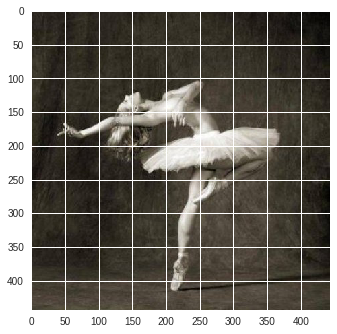

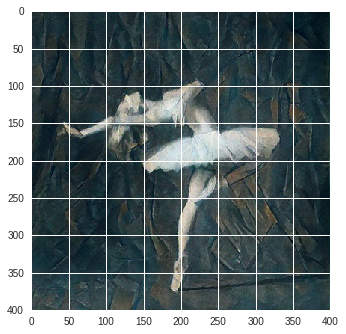

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.figure()
img=mpimg.imread('dancing.png',0)
imgplot = plt.imshow(img)
plt.show()

plt.figure()
img=mpimg.imread('output-5000.png')
imgplot = plt.imshow(img)
plt.show()